In [1]:
import numpy as np

In [2]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

In [3]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

In [4]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss  = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

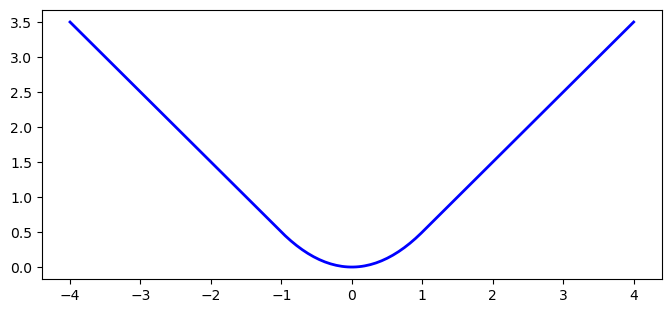

In [5]:
plt.figure(figsize=(8, 3.5))
z = np.linspace(-4, 4, 200)
plt.plot(z, huber_fn(0, z), "b-", linewidth=2, label="huber($z$)")

In [6]:
input_shape = X_train.shape[1:]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="selu", kernel_initializer="lecun_normal",
                       input_shape=input_shape),
    keras.layers.Dense(1),
])

In [7]:
model.compile(loss=huber_fn, optimizer="nadam", metrics=["mae"])

In [8]:
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
363/363 [==============================] - 12s 13ms/step - loss: 0.6005 - mae: 0.9563 - val_loss: 0.3331 - val_mae: 0.6259
Epoch 2/2
363/363 [==============================] - 5s 13ms/step - loss: 0.2165 - mae: 0.5097 - val_loss: 0.2742 - val_mae: 0.5607


In [9]:
model.save("my_custom_loss_model.h5")

C:\Users\dread-miles\miniconda3\envs\snakey\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [10]:
load_model=keras.models.load_model("my_custom_loss_model.h5",custom_objects={"huber_fn":huber_fn})

In [11]:
def create_huber(threshold):
    def huber_fn(y_true,y_pred):
        error=y_true-y_pred
        is_small_error=tf.abs(error)<threshold
        squared_loss=tf.square(error)/2
        linear_loss=threshold*tf.abs(error)-threshold**2/2
        return tf.where(is_small_error,squared_loss,linear_loss)
    return huber_fn

In [12]:
# lets put some threshold into our loss function
model.compile(loss=create_huber(1.0),optimizer="nadam",metrics=["mae"])

In [13]:
model.fit(X_train_scaled,y_train,epochs=3,validation_data=(X_valid,y_valid))

Epoch 1/3
363/363 [==============================] - 12s 12ms/step - loss: 0.2056 - mae: 0.4945 - val_loss: 79.5559 - val_mae: 80.0559
Epoch 2/3
363/363 [==============================] - 2s 6ms/step - loss: 0.1974 - mae: 0.4844 - val_loss: 105.0474 - val_mae: 105.5474
Epoch 3/3
363/363 [==============================] - 2s 6ms/step - loss: 0.1912 - mae: 0.4748 - val_loss: 70.2424 - val_mae: 70.7424


In [14]:
# lets customize from the keras 
class HubberLoss(keras.losses.Loss):
    def __init__(self,threshold,**kwargs):
        self.threshold=threshold
        super().__init__(**kwargs)
    def call(self,y_true,y_pred):
        error=y_true-y_pred
        is_small_error=tf.abs(error)<self.threshold
        squared_loss=tf.square(error)/2
        linear_loss=self.threshold * tf.abs(error)-self.threshold**2/2
        return tf.where(is_small_error,squared_loss,linear_loss)
    def get_config(self):
        base_config=super().get_config()
        return {**base_config,"threshold":self.threshold}

In [15]:
model2=keras.models.Sequential(
    [
        keras.layers.Dense(30,activation="selu",kernel_initializer="lecun_normal"),
        keras.layers.Dense(1)
    ]
)

In [16]:
model2.compile(loss=HubberLoss(2.),optimizer="nadam",metrics=["mse"])

In [17]:
model2.fit(X_train_scaled,y_train,epochs=5,validation_data=(X_valid,y_valid))

Epoch 1/5
363/363 [==============================] - 5s 6ms/step - loss: 0.8613 - mse: 1.9394 - val_loss: 1111.5826 - val_mse: 525103.4375
Epoch 2/5
363/363 [==============================] - 2s 7ms/step - loss: 0.2545 - mse: 0.5317 - val_loss: 839.4847 - val_mse: 287835.5625
Epoch 3/5
363/363 [==============================] - 5s 13ms/step - loss: 0.2342 - mse: 0.4828 - val_loss: 808.2312 - val_mse: 261580.0469
Epoch 4/5
363/363 [==============================] - 6s 16ms/step - loss: 0.2260 - mse: 0.4608 - val_loss: 813.8699 - val_mse: 263895.0312
Epoch 5/5
363/363 [==============================] - 4s 10ms/step - loss: 0.2218 - mse: 0.4536 - val_loss: 732.8983 - val_mse: 209608.4062


In [18]:
model2.save("my_custom_loss_fn.h5")

In [19]:
#load_saved_model2=keras.models.load_model("my_custom_loss_fn.h5",custom_objects={"hubber loss":HubberLoss})

In [20]:
keras.backend.clear_session

<function keras.src.backend.clear_session()>

In [21]:
#other custom functions
def my_softplus(z): # return value is just tf.nn.softplus(z)
    return tf.math.log(tf.exp(z) + 1.0)
def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)
def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))
def my_positive_weights(weights): # return value is just tf.nn.relu(weights)
    return tf.where(weights < 0., tf.zeros_like(weights), weights)

# customize the layer

In [22]:
keras.backend.clear_session

<function keras.src.backend.clear_session()>

In [23]:
model=keras.models.Sequential([
    keras.layers.Dense(25,kernel_initializer="lecun_normal",input_shape=input_shape),
    keras.layers.Dense(1,activation=my_softplus,
                      kernel_initializer=my_glorot_initializer,
                      kernel_regularizer=my_l1_regularizer,
                      kernel_constraint=my_positive_weights
                      )
])

In [24]:
model.compile(loss="mse",optimizer="nadam",metrics=["mse"])

In [25]:
model.fit(X_train_scaled,y_train,epochs=3,validation_data=[X_valid,y_valid])

Epoch 1/3
363/363 [==============================] - 6s 7ms/step - loss: 1.7330 - mse: 1.6896 - val_loss: inf - val_mse: inf
Epoch 2/3
363/363 [==============================] - 2s 7ms/step - loss: 0.5629 - mse: 0.5163 - val_loss: inf - val_mse: inf
Epoch 3/3
363/363 [==============================] - 3s 7ms/step - loss: 0.5297 - mse: 0.4825 - val_loss: inf - val_mse: inf


In [26]:
from keras.utils import custom_object_scope

In [27]:
model.save("my_heavly_regularized.h5")

In [28]:
'''
loaded_model = keras.models.load_model(
    "my_heavly_regularized.h5",
    custom_objects={
       "my_glorot_initializer": my_glorot_initializer,
        "my_l1_regularizer":my_l1_regularizer,
       "my_positive_weights": my_positive_weights,
       "my_softplus": my_softplus,
    })
    '''

'\nloaded_model = keras.models.load_model(\n    "my_heavly_regularized.h5",\n    custom_objects={\n       "my_glorot_initializer": my_glorot_initializer,\n        "my_l1_regularizer":my_l1_regularizer,\n       "my_positive_weights": my_positive_weights,\n       "my_softplus": my_softplus,\n    })\n    '

In [29]:
#model_config=loaded_model.get_config()

# custom metrics

In [30]:
keras.backend.clear_session()

In [31]:
# lets use the huber function as a metric
model=keras.models.Sequential([
    keras.layers.Dense(35,kernel_initializer="lecun_normal"),
    keras.layers.Dense(1)
])
model.compile(loss=huber_fn,optimizer="nadam",metrics=[create_huber(2.)])

In [32]:
model.fit(X_train_scaled,y_train,epochs=3)

Epoch 1/3
363/363 [==============================] - 3s 3ms/step - loss: 0.6115 - huber_fn: 0.8350
Epoch 2/3
363/363 [==============================] - 2s 5ms/step - loss: 0.2178 - huber_fn: 0.2578
Epoch 3/3
363/363 [==============================] - 1s 4ms/step - loss: 0.2169 - huber_fn: 0.2563


In [33]:
#making custom metric 
class HuberMetric(keras.metrics.Metric):
    def __init__(self,threshold,**kwargs):
        super().__init__(**kwargs)
        self.threshold=threshold
        self.huber_fn=create_huber(threshold)
        self.total=self.add_weight("total",initializer="zeros")
        self.count=self.add_weight("count",initializer="zeros")
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        metric = self.huber_fn(y_true, y_pred)
        if sample_weight is not None:
            metric *= sample_weight
            self.count.assign_add(tf.reduce_sum(sample_weight))
        else:
            self.count.assign_add(tf.cast(tf.size(y_true), tf.float32))

        self.total.assign_add(tf.reduce_sum(metric))
        
    def result(self):
        return self.total/self.count
    def get_config(self):
        base_config=super().get_config()
        return {**base_config,"threshold":self.threshold}

In [34]:
# lets test our custom metric
metric=HuberMetric(2.)  #this is the threshold

metric(tf.constant([[2.]]),tf.constant([[3.]]))
print(metric)

HuberMetric(name=huber_metric,dtype=float32,threshold=2.0)


In [35]:
#lets try it for an array
metric_2=HuberMetric(4.)
#...
metric_2(tf.constant([[12.],[23.],[2.]]),tf.constant([[100.],[100.],[100.]]))
metric_2.result()

<tf.Tensor: shape=(), dtype=float32, numpy=342.66666>

In [36]:
metric_2.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=1028.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=3.0>]

In [37]:
metric_2.reset_states()
metric_2.variables

[<tf.Variable 'total:0' shape=() dtype=float32, numpy=0.0>,
 <tf.Variable 'count:0' shape=() dtype=float32, numpy=0.0>]

In [38]:
metric_2(tf.constant([[12.],[23.],[2.]]),tf.constant([[100.],[100.],[100.]]))
metric_2.result()

<tf.Tensor: shape=(), dtype=float32, numpy=342.66666>

In [39]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [40]:
# lets putit to model
model=keras.models.Sequential([
    keras.layers.Dense(12,activation="elu"),
    keras.layers.Dense(1)
])

In [41]:
model.compile(loss=create_huber(2.0),optimizer="nadam",metrics=[HuberMetric(2.0)])

In [42]:
model.fit(X_train_scaled.astype(np.float32),y_train.astype(np.float32),epochs=3)

Epoch 1/3
363/363 [==============================] - 4s 4ms/step - loss: 1.0326 - huber_metric: 1.0326
Epoch 2/3
363/363 [==============================] - 1s 3ms/step - loss: 0.2653 - huber_metric: 0.2653
Epoch 3/3
363/363 [==============================] - 1s 4ms/step - loss: 0.2338 - huber_metric: 0.2338


In [43]:
model.save("made_with_custom_metric.h5")

In [44]:
loaded_model=keras.models.load_model("made_with_custom_metric.h5",custom_objects={"huber_fn":huber_fn,
                                                                                  "HuberMetric":HuberMetric
})

# more customizing layers

In [45]:
exponential_layer=keras.layers.Lambda(lambda x: tf.exp(x))

In [46]:
exponential_layer([2.])

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([7.389056], dtype=float32)>

In [47]:
exponential_layer([-1.,0.2,3.])

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0.36787945,  1.2214028 , 20.085537  ], dtype=float32)>

In [48]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [49]:
# lets make a simple layer with our "activation function"
model=keras.models.Sequential([
    keras.layers.Dense(24,activation="relu"),
    keras.layers.Dense(1),
    exponential_layer
])

In [50]:
model.compile(loss="mse",optimizer="sgd")

In [51]:
model.fit(X_train_scaled,y_train,epochs=4,validation_data=(X_valid,y_valid))
eval=model.evaluate(X_test,y_test)
print(eval)

Epoch 1/4
363/363 [==============================] - 2s 4ms/step - loss: 13.6067 - val_loss: 5.4561
Epoch 2/4
363/363 [==============================] - 1s 4ms/step - loss: 5.6755 - val_loss: 5.4561
Epoch 3/4
363/363 [==============================] - 1s 4ms/step - loss: 5.6755 - val_loss: 5.4561
Epoch 4/4
162/162 [==============================] - 1s 3ms/step - loss: 5.5800
5.579954147338867


In [52]:
#inherited format yey
class MyDense(keras.layers.Dense):
    def __init__(self,units,activation=None,**kwargs):
        super(MyDense,self).__init__(**kwargs)
        self.activation=keras.activations.get(activation)
        self.units=units
        
    #this builds the architecture of the model
    def build(self,batch_input_shape):
        self.kernel=self.add_weight(name="kernel",shape=[batch_input_shape[-1],self.units],initializer="glorot_normal",trainable=True)
        self.bias=self.add_weight(name="bias", shape=[self.units],initializer="zeros",trainable=True)
        super().build(batch_input_shape)
        
    #this is the feed forward method
    def call(self,X):
        return self.activation(tf.matmult(X, self.kernel) + self.bias)

    #this determines the outputs shape
    def compute_output_shape(batch_input_shape):
        return tf.TensorShape((batch_input_shape[0],[self.units]))
    
    def get_config(self,**kwargs):
        base_config=super().get_config()
        return {**base_config,"units":self.units,
                            "activation":keras.activations.serialize(self.activation)}

In [53]:
# lets create a model
'''
my_model=keras.models.Sequential([
    MyDense(units=23,activation="relu",input_shape=input_shape),
    MyDense(units=1)
])
'''

'\nmy_model=keras.models.Sequential([\n    MyDense(units=23,activation="relu",input_shape=input_shape),\n    MyDense(units=1)\n])\n'

In [54]:
# letr create a multi layer
class MyMultiLayer(keras.layers.Layer):
    def call(self,X):
        x1,x2=X
        print("x1.shape: ",x1.shape," x2.shape :",x2.shape)
        return x1+x2,x1*x2
    def compute_output_shape(self,batch_input_shape):
        batch_input_1,batch_input_2=batch_input_shape
        return [batch_input_1,batch_input_2]

In [55]:
inputs1 = keras.layers.Input(shape=[2])
inputs2 = keras.layers.Input(shape=[2])
outputs1, outputs2 = MyMultiLayer()((inputs1, inputs2))

x1.shape:  (None, 2)  x2.shape : (None, 2)


In [56]:
def split_data(data):
    columns_count = data.shape[-1]
    half = columns_count // 2
    return data[:, :half], data[:, half:]

X_train_scaled_A, X_train_scaled_B = split_data(X_train_scaled)
X_valid_scaled_A, X_valid_scaled_B = split_data(X_valid_scaled)
X_test_scaled_A, X_test_scaled_B = split_data(X_test_scaled)

In [57]:
outputs1, outputs2 = MyMultiLayer()((X_train_scaled_A, X_train_scaled_B))

x1.shape:  (11610, 4)  x2.shape : (11610, 4)


In [58]:
#lets build a more sophisticated model
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

input_a=keras.layers.Input(X_train_scaled_A.shape[-1])
input_b=keras.layers.Input(X_train_scaled_B.shape[-1])

hidden_a,hidden_b=MyMultiLayer()((input_a,input_b))

hidden_a=keras.layers.Dense(34,activation="relu")(hidden_a)
hidden_b=keras.layers.Dense(34,activation="relu")(hidden_b)
concat=keras.layers.Concatenate()((hidden_a,hidden_b))
output=keras.layers.Dense(1)(concat)
model=keras.models.Model(inputs=[input_a,input_b],outputs=[output])

x1.shape:  (None, 4)  x2.shape : (None, 4)


In [59]:
model.compile(loss='mse', optimizer='nadam')

In [60]:
model.fit((X_train_scaled_A,X_train_scaled_B),y_train,epochs=3,validation_data=((X_valid_scaled_A,X_valid_scaled_B),y_valid))

Epoch 1/3
x1.shape:  (None, 4)  x2.shape : (None, 4)
x1.shape:  (None, 4)  x2.shape : (None, 4)
363/363 [==============================] - 5s 6ms/step - loss: 2.1420 - val_loss: 8.4880
Epoch 2/3
363/363 [==============================] - 2s 5ms/step - loss: 1.0664 - val_loss: 3.8667
Epoch 3/3
363/363 [==============================] - 2s 4ms/step - loss: 0.9368 - val_loss: 2.3327


# lets add Noise to our data 

In [61]:
class AddGaussianNoise(keras.layers.Layer):
    def __init__(self, stddev, **kwargs):
        super().__init__(**kwargs)
        self.stddev = stddev

    def call(self, X, training=None):
        if training:
            noise = tf.random.normal(tf.shape(X), stddev=self.stddev)
            return X + noise
        else:
            return X

    def compute_output_shape(self, batch_input_shape):
        return batch_input_shape

In [62]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    AddGaussianNoise(stddev=1.0),
    keras.layers.Dense(30, activation="selu"),
    keras.layers.Dense(1)
])

In [63]:
model.compile(loss="mse", optimizer="nadam")
model.fit(X_train_scaled, y_train, epochs=2,
          validation_data=(X_valid_scaled, y_valid))
model.evaluate(X_test_scaled, y_test)

Epoch 1/2
363/363 [==============================] - 4s 5ms/step - loss: 2.3432 - val_loss: 2.0158
Epoch 2/2
162/162 [==============================] - 0s 3ms/step - loss: 0.7169


0.7169358134269714

# Custom models

In [80]:
#lets make a custom models
class ResidualBlock(keras.layers.Layer):
    def __init__(self,n_hidden,n_neurons,**kwargs):
        super().__init__(**kwargs)
        self.hidden=[keras.layers.Dense(n_neurons,kernel_initializer="he_normal",activation="elu") for _ in range(n_hidden)]
        
    def call(self,input):
        tmp=input
        for layer in self.hidden:
            tmp=layer(tmp)
        return tmp+tmp #this is based on the residual arctitecture from the book

In [84]:
# lets build a regressor based on the above class
class ResidualRegressor(keras.Model):
    def __init__(self,output_dims,**kwargs):
        super().__init__(**kwargs)
        self.hidden=keras.layers.Dense(30,activation="relu",kernel_initializer="he_normal")
        self.block1=ResidualBlock(n_hidden=3,n_neurons=30)
        self.block2=ResidualBlock(n_hidden=2,n_neurons=30)
        self.out=keras.layers.Dense(output_dims)
                                      
    def call(self,input):
        temp=self.hidden(input)
        for _ in range(1+4): 
            temp=self.block1(temp)
        self.out=self.block2(temp)
        return self.out

In [85]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [89]:
#lets implement the model
model=ResidualRegressor(1)  #one is the number of output or the dims
model.compile(optimizer="nadam",loss="mse")
model.fit(X_train_scaled,y_train,epochs=5)

Epoch 1/5
363/363 [==============================] - 10s 6ms/step - loss: 13.9747
Epoch 2/5
363/363 [==============================] - 3s 7ms/step - loss: 1.4387
Epoch 3/5
363/363 [==============================] - 2s 6ms/step - loss: 1.0332
Epoch 4/5
363/363 [==============================] - 2s 6ms/step - loss: 0.8254
Epoch 5/5
363/363 [==============================] - 2s 6ms/step - loss: 0.7100


In [90]:
model.save("my_cusotm_model.ckpt")

INFO:tensorflow:Assets written to: my_cusotm_model.ckpt\assets


INFO:tensorflow:Assets written to: my_cusotm_model.ckpt\assets


In [91]:
my_custom_model=keras.models.load_model("my_cusotm_model.ckpt")

In [94]:
#lets make a models using the residual block and sequential API
block=ResidualBlock(2,30)
model=keras.models.Sequential([
    keras.layers.Dense(30),
    block,block,block,block,
    keras.layers.Dense(1)
])

In [96]:
model.compile(loss="mse",optimizer="nadam")

In [98]:
model.fit(X_train_scaled,y_train,epochs=4)

Epoch 1/4
363/363 [==============================] - 2s 7ms/step - loss: 0.4418
Epoch 2/4
363/363 [==============================] - 2s 4ms/step - loss: 0.4384
Epoch 3/4
363/363 [==============================] - 2s 6ms/step - loss: 0.4339
Epoch 4/4
363/363 [==============================] - 2s 6ms/step - loss: 0.3818


In [99]:
model.evaluate(X_test_scaled,y_test)

162/162 [==============================] - 2s 5ms/step - loss: 0.3744


0.37440377473831177

# loss and metric based on the internals of the model

In [121]:
# custom loss based on other part of the model
class ReconstractingRegressor(keras.Model):
    
    def __init__(self,output_dim,**kwargs):
        super().__init__(**kwargs)
        self.hidden=[keras.layers.Dense(30,activation="selu",kernel_initializer="lecun_normal") for _ in range(5)]
        self.out=keras.layers.Dense(output_dim)
        self.reconstraction_mean=keras.metrics.Mean(name="reconstruction_error")  #for the reconstruction error 
   
    def build(self,batch_input_shape):
        input_shape=batch_input_shape[-1]  #this gets the input feature
        self.reconstruct=keras.layers.Dense(input_shape)
        
    def call(self,input):
        temp=input
        for layer in self.hidden:
            temp=layer(temp)
        reconstruction=self.reconstruct(temp)
        reconstruct_loss=tf.reduce_mean(tf.square(reconstruction-input))
        self.add_loss(0.05*reconstruct_loss)
        '''
        if training:
            result=self.reconstruction_mean(reconstruct_loss)
            self.add_metric(result)
        '''
        return self.out(temp)

In [122]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [123]:
model=ReconstractingRegressor(1)
model.compile(optimizer="nadam",loss="mse")

In [124]:
model.fit(X_train_scaled,y_train,epochs=4)

Epoch 1/4
363/363 [==============================] - 12s 14ms/step - loss: 0.7005 - reconstruction_error: 0.0000e+00
Epoch 2/4
363/363 [==============================] - 3s 8ms/step - loss: 0.4220 - reconstruction_error: 0.0000e+00
Epoch 3/4
363/363 [==============================] - 5s 12ms/step - loss: 0.3821 - reconstruction_error: 0.0000e+00
Epoch 4/4
363/363 [==============================] - 6s 17ms/step - loss: 0.3669 - reconstruction_error: 0.0000e+00


In [126]:
model_predicted=model.predict(X_test_scaled)

162/162 [==============================] - 1s 4ms/step


In [127]:
model.evaluate(X_test_scaled,y_test)

162/162 [==============================] - 1s 5ms/step - loss: 0.3920 - reconstruction_error: 0.0000e+00


[0.39197298884391785, 0.0]